In [75]:
import numpy as np
import pandas as pd
import mdtraj as md
import nglview as ngl
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob, os, re, sys, subprocess
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from tempfile import gettempdir
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.database.rcsb as rcsb
import biotite.database.entrez as entrez
import biotite.application.dssp as dssp

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"]
        )


class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0

        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height, self._head_width*bbox.height,
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.5, draw_head=draw_head,
            color=biotite.colors["orange"], linewidth=0
        ))

# Test our drawing functions with example annotation
ubq_sec_annotation = seq.Annotation([
    seq.Feature("SecStr", [seq.Location(1, 7)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(10, 17)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(23, 34)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(40, 45)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(48, 50)], {"sec_str_type" : "sheet"}),
    seq.Feature("SecStr", [seq.Location(56, 59)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(64, 72)], {"sec_str_type" : "sheet"}),
])

In [35]:
def make_15_N_table(in_file, out_file=None, return_df=True, split_prox_dist=False):
    with open(in_file, 'r') as f:
        lines = f.read().splitlines()
    lines = list(filter(lambda x: False if x == '' else True, lines))

    names = lines[0].lstrip('%<').rstrip('>').split('><') + ['is in secondary']
    df = {n: [] for n in names}

    for line in lines[1:]:
        for i, data in enumerate(line.split()):
            if '*' in data and i == 0:
                df['is in secondary'].append(False)
                data = data.lstrip('*')
            elif '*' not in data and i == 0:
                df['is in secondary'].append(True)
            try:
                df[names[i]].append(float(data))
            except ValueError:
                df[names[i]].append(data)
    df['position'] = list(map(lambda x: 'proximal' if x == 'A' else 'distal', df['chain id']))
    df = pd.DataFrame(df)
    
    mhzs = df['freq of spectrometer (MHz)'].unique()
    for mhz in mhzs:
        rho = []
        rho2 = []
        for i, resnum in enumerate(df['residue number']):
            if df['freq of spectrometer (MHz)'][i] != mhz:
                continue
            if not df['is in secondary'][i]:
                continue
            if df['chain id'][i] == 'B' and not split_prox_dist:
                resnum += 76
            R1 = df['R1 rate (1/s)'][i]
            R1_err = df['R1 rate error (1/s)'][i]
            R2 = df['R2 rate (1/s)'][i]
            R2_err = df['R1 rate error (1/s)'][i]
            NOE = df['NOE'][i]
            NOE_err = df['NOE error'][i]
            if not split_prox_dist:
                rho.append([int(resnum), R1, R1_err, R2, R2_err, NOE, NOE_err])
            else:
                if df['chain id'][i] == 'A':
                    rho.append([int(resnum), R1, R1_err, R2, R2_err, NOE, NOE_err])
                else:
                    rho2.append([int(resnum), R1, R1_err, R2, R2_err, NOE, NOE_err])
        if out_file is not None:
            if not '*' in out_file:
                raise Exception("Method will write two files. Please provide a filename with wildcard (*).")
            filename = out_file.replace('*', str(int(mhz)))
            if not split_prox_dist:
                with open(filename, 'w') as f:
                    for r in rho:
                        f.write(' '.join(map(str, r)) + '\n')
                print(filename, 'written')
            else:
                fnames = [filename.replace('.tbl', '_proximal.tbl'), filename.replace('.tbl', '_distal.tbl')]
                for fname, r in zip(fnames, [rho, rho2]):
                    with open(fname, 'w') as f:
                        for _ in r:
                            f.write(' '.join(map(str, _)) + '\n')
                print(fnames, 'written')
        else:
            print(mhz)
            out = []
            for r in rho + rho2:
                out.append(' '.join(map(str, r)) + '\n')
            print(''.join(out))
    if return_df:
        df = df.rename(columns={'residue number': 'resSeq'})
        df['resSeq'] = df['resSeq'].astype(int)
        max_ = df[df['chain id'] == 'A']['resSeq'].max()
        df['resSeq'] = df.apply(lambda row: row.resSeq + max_ if row['chain id'] == 'B' else row.resSeq, axis=1)
        df = df.sort_values(by=['freq of spectrometer (MHz)', 'chain id', 'resSeq'], axis='rows')
        return(df)
            
def label(resSeq, sPRE, err=0.01):
    return f"assign (resid {resSeq:<2} and name HN)	{sPRE:5.3f}	{err:5.3f}"

def getResSeq(lines):
    return list(map(lambda x: int(x.split('\t')[0][3:]), filter(lambda x: False if (x == '' or 'mM' in x or 'primary' in x) else True, lines)))
    
def make_sPRE_table(in_files, out_file=None, return_df=True, split_prox_dist=False):
    files = glob.glob(in_files)
    files = sorted(files, key=lambda x: 1 if ('proximal' in x or 'prox' in x) else 2)
    assert len(files) == 2, print(f"I need a proximal and a distal file. I found {files}")
    proximal, distal = files
    
    file = proximal
    new_lines = []
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    for i, l in enumerate(lines):
        if l == '' or i == 1:
            continue
        if i == 0:
            main_labels = l.split('\t')
            df = {k: [] for k in main_labels}
            continue
        for k, v in zip(main_labels, l.split('\t')):
            df[k].append(v)
    df['resSeq'] = getResSeq(lines)
    df['position'] = np.full(len(df['resSeq']), 'proximal').tolist()

    file = distal
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    for i, l in enumerate(lines):
        if l == '' or i == 0 or i == 1:
            continue
        for k, v in zip(main_labels, l.split('\t')):
            df[k].append(v)
    max_ = max(df['resSeq'])
    resSeq = list(map(lambda x: x + max_, getResSeq(lines)))
    df['resSeq'].extend(resSeq)
    df['position'].extend(np.full(len(resSeq), 'distal').tolist())
    df = pd.DataFrame(df)
    
    df['sPRE'] = pd.to_numeric(df['sPRE'], errors='coerce')
    df['err'] = pd.to_numeric(df['err'], errors='coerce')
    
    if out_file is not None:
        if not split_prox_dist:
            with open(out_file, 'w') as f:
                for i, row in df.iterrows():
                    if any(pd.isna(row)):
                        continue
                    new_line = label(row['resSeq'], row['sPRE'], row['err'])
                    f.write(new_line + '\n')
            print(out_file, 'written')
        else:
            fnames = [out_file.replace('.tbl', '_proximal.tbl'), out_file.replace('.tbl', '_distal.tbl')]
            for i, fname in enumerate(fnames):
                if i == 0:
                    sub_df = df[df['position'] == 'proximal']
                    print(sub_df)
                else:
                    sub_df = df[df['position'] == 'distal']
                with open(fname, 'w') as f:
                    for j, row in sub_df.iterrows():
                        if any(pd.isna(row)):
                            continue
                        if i == 0:
                            new_line = label(row['resSeq'], row['sPRE'], row['err'])
                        else:
                            new_line = label(row['resSeq'] - max_, row['sPRE'], row['err'])
                        f.write(new_line + '\n')
            print(fnames, 'written')
    if return_df:
        return df

# 17.05.2021 diUb/XPLOR

## Failures:

### No isopeptide possible.

XPLOR does not respect the isopeptide bond between the Ub subunits, although, the bonds are specified in the input pdb fie.
```
...
ATOM   1519  C   GLY A 152      88.453  90.127  32.383  1.00  0.00           C  
ATOM   1520  O   GLY A 152      87.873  89.867  31.313  1.00  0.00           O  
ATOM   1521  OXT GLY A 152      89.513  90.777  32.443  1.00  0.00           O  
TER    1522      GLY A 152
ENDMDL
CONECT  760  762
CONECT  762  760
END
```

In [144]:
for i, f in enumerate(glob.glob('test_CONECT/2021-05-04T15:18:55+02:00_dyanmics_run_*.pdb')):
    if i == 0:
        traj1 = md.load(f)
    else:
        traj1 = traj1.join(md.load(f))
view1 = ngl.show_mdtraj(traj1)
view1.clear_representations()
view1.add_representation('ball+stick')

In [147]:
view1

NGLWidget(max_frame=999, n_components=1)

### Dynamics seemed weird

Only using one subunit removes the need for an isopeptide bond (peptides can be stuck together after refinement).

In [106]:
files = glob.glob("long_xplor_sim/proximal/2021-05-05T14:42:40+02:00_dynamics_run_*.pdb")
for i, file in enumerate(files):
    if i == 0:
        traj_out = md.load(file)
    else:
        _ = md.load(file)
        traj_out = traj_out.join(_)
view = ngl.show_mdtraj(traj_out)
view.clear_representations()
view.add_representation('ball+stick')
view.center()

In [22]:
view

NGLWidget(max_frame=999)

## Try new protocol

**New features**

More potentials:

| Number      | Potential                           | Description                                                                                                           |
|-------------|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| 1           | RelaxRatioPot (600 MHz)             | 15-N Relaxation time (R1, R2) in $\mathrm{s^{-1}}$ and NOE at 600 MHz                                                 |
| 2           | RelaxRatioPot (800 MHz              | 15-N Relaxation times (R1, 2) in $\mathrm{s^{-1}}$ and NOE at 800 MHz                                                 |
| 3           | PSolPot                             | sPRE values in $\mathrm{mM^{-1}s^{-1}}$                                                                               |
| 4           | TorsionDBPot                        | statistical torsion angle potential (torsionDB)                                                                       |
| 5           | RepelPot                            | interatomic repulsion potential (van der Waals-like term)                                                             |
| 6           | Terminal14Pot                       | 1-4 interactions, used to reduce the exaggeration of short-range repulsion caused by the 6–12 Lennard-Jones potential |
| 7, 8, 9, 10 | Bonds, Angles, Dihedrals, Impropers | Energy terms for bonds, angles, etc.                                                                                  |

New protocol:

| Stage | Name                       | Description                                                                                   |
|-------|----------------------------|-----------------------------------------------------------------------------------------------|
| 1     | High Temperature Dynamics  | Dynamics at 3000 K. Allows protein to move in large steps possibly breaking energy barriers.  |
| 2     | Simulated Annealing        | Cooling of system to 25 K. And slowly ramping up potentials.                                  |
| 3     | Torsion Angle Minimization | Move cooled system slowly to minimal potential values.                                        |
| 4     | Cartesian Minimization     | Move cooled system slowly to minimal potential values.                                        |

### Dynamics of new protocol

In [107]:
for i, f in enumerate(glob.glob('mol_biol_example/proximal_sim/sim_*.pdb')):
    _ = md.load(f)
    _ = _.atom_slice(_.top.select('protein'))
    if i == 0:
        traj = _
    else:
        traj = traj.join(_)
view = ngl.show_mdtraj(traj)
view

NGLWidget(max_frame=201)

### Some results

These are the results returned by the new protocol.

```
 Energy terms used for sorting:
  BOND ANGL IMPR DIHE

                                     sort        fit      comparison
Filename:                           energy       RMSD       RMSD
-f_75.pdb                           182.11     10.728     10.728
-f_14.pdb                           200.51      9.574      9.574
-f_12.pdb                           207.45     10.226     10.226
-f_43.pdb                           207.46     11.867     11.867
-f_94.pdb                           212.53      9.402      9.402
-f_65.pdb                           216.95      9.731      9.731
-f_79.pdb                           256.55     10.634     10.634
-f_37.pdb                           263.41     11.763     11.763
-f_90.pdb                           277.44     13.836     13.836
-f_95.pdb                           670.60     12.003     12.003

average:                                       10.976     10.976
```

### L-BFGS minimization

Minimizing the structure still does not bring back the secondary structure motifs.

In [27]:
view = ngl.show_file('mol_biol_example/k6_proximal_l-bfgs/eq5.gro')
view.add_component('mol_biol_example/2017_04_27_G_2ub_k6_01_01_proximal.pdb')
view

NGLWidget()

### Lower Temperature

Doesn't change overall dynamics. They just take longer.

In [108]:
for i, f in enumerate(glob.glob('mol_biol_example/k6_proximal_low_temp/*.pdb')):
    _ = md.load(f)
    _ = _.atom_slice(_.top.select('protein'))
    if i == 0:
        traj = _
    else:
        traj = traj.join(_)
view = ngl.show_mdtraj(traj)
view

NGLWidget(max_frame=99)

## Can these structures be trusted?

No, because...

- Ubq is known to be very stable. A breaking of sec struct motifs is highly unlikely.
- sPRE Values of result show greater difference, than crystal structure. Longer sims?

Maybe, because...

- The MD Force Field GROMOS54a7 is known to produce "sticky proteins" keeping them stuck together.

Yes, because...

- Conformation conservation better than previously failed simulations.
- sPRE values are being minimized. Longer sims?

## Comparison sPRE vaues K6 proximal distal.

Try to do similar plots to Tobi's presentation.

In [39]:
K6_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt', split_prox_dist=True)
real = K6_sPRE[K6_sPRE['position'] == 'proximal']['sPRE'].values
real[np.isnan(real)] = 0

In [88]:
out = "[['rrp800', '2', 14.66987681213716], ['rrp800', '3', 12.190341635047558], ['rrp800', '4', 13.627494265826599], ['rrp800', '5', 13.954471478517997], ['rrp800', '12', 11.519081587228618], ['rrp800', '13', 12.879244413789491], ['rrp800', '14', 12.851548588921757], ['rrp800', '15', 13.767768700771034], ['rrp800', '16', 11.868677740525479], ['rrp800', '22', 12.127313524182886], ['rrp800', '23', 13.863506440100862], ['rrp800', '25', 15.441114015195634], ['rrp800', '26', 11.522837658539192], ['rrp800', '27', 12.260239990648325], ['rrp800', '28', 11.895011273956111], ['rrp800', '29', 11.757108808498556], ['rrp800', '30', 13.312168135330182], ['rrp800', '31', 11.634330814687985], ['rrp800', '32', 13.15585929616015], ['rrp800', '33', 12.243622145437724], ['rrp800', '34', 12.828156533082012], ['rrp800', '35', 13.72331452164922], ['rrp800', '39', 12.65401438020491], ['rrp800', '41', 13.040690386654779], ['rrp800', '42', 13.15749854059476], ['rrp800', '43', 13.31264452903251], ['rrp800', '44', 12.2670625158222], ['rrp800', '45', 12.577425941652466], ['rrp800', '48', 13.605924339811049], ['rrp800', '49', 11.820049462639364], ['rrp800', '56', 11.66588715797127], ['rrp800', '57', 12.925615271097765], ['rrp800', '58', 12.418135543929866], ['rrp800', '59', 12.574217994193022], ['rrp800', '60', 14.256705647974695], ['rrp800', '66', 12.358357366461567], ['rrp800', '67', 12.864404227814742], ['rrp800', '68', 13.269404341854143], ['rrp800', '69', 13.75065832473511], ['rrp800', '70', 15.828270942021486], ['rrp800', '71', 12.674717703233513], ['psol', '2', 0.9874866112560609], ['psol', '3', 0.358355881104227], ['psol', '4', 0.3881259237710278], ['psol', '5', 0.4634585732941753], ['psol', '7', 0.45176661664786455], ['psol', '8', 0.7953746305129672], ['psol', '10', 1.0151782060868224], ['psol', '11', 0.7465523695852567], ['psol', '12', 0.7256361563818952], ['psol', '13', 0.4153900750528355], ['psol', '14', 0.3827267259120445], ['psol', '15', 0.44908307160341043], ['psol', '16', 0.3904215113153093], ['psol', '17', 0.572956470788017], ['psol', '18', 0.382553213486183], ['psol', '20', 0.26981436829171135], ['psol', '22', 0.2028453059706355], ['psol', '23', 0.45001604509882537], ['psol', '26', 0.23376484968778116], ['psol', '27', 0.29892473609404646], ['psol', '28', 0.3396806397318089], ['psol', '29', 0.5167155522915702], ['psol', '30', 0.47119565202782754], ['psol', '31', 0.7507359881413386], ['psol', '32', 0.41913539053486093], ['psol', '33', 0.3030059508154511], ['psol', '35', 0.3734025858030367], ['psol', '36', 0.3918527564367644], ['psol', '39', 0.41461678651369893], ['psol', '41', 0.42737234089182313], ['psol', '42', 0.35155315701596956], ['psol', '43', 0.4026375164861975], ['psol', '44', 0.4886358372341099], ['psol', '45', 0.7905272426462046], ['psol', '46', 1.023072387555729], ['psol', '47', 0.7579944042424541], ['psol', '48', 0.42284234481167515], ['psol', '49', 0.374625017166284], ['psol', '50', 0.4831498977738733], ['psol', '51', 0.4558312001073616], ['psol', '52', 0.3190107632719463], ['psol', '54', 0.5523791121888157], ['psol', '55', 0.41898956150648486], ['psol', '56', 0.4407487177738772], ['psol', '57', 0.7351836714152867], ['psol', '58', 0.5385466719929004], ['psol', '59', 0.5242271718094285], ['psol', '60', 0.4241469162507803], ['psol', '61', 0.6395512008982448], ['psol', '62', 0.4300828497516453], ['psol', '63', 0.5547019312792006], ['psol', '64', 0.5452869151107059], ['psol', '65', 0.9662478429948387], ['psol', '66', 0.5435347141225881], ['psol', '68', 0.4376692368301773], ['psol', '69', 0.3781439930324157], ['psol', '70', 0.3895129299772957], ['psol', '71', 0.4063625305036618], ['psol', '73', 0.47783047514148685], ['psol', '74', 0.7996397782055416], ['psol', '75', 0.9226951812133238]]"
import ast
out = ast.literal_eval(out)
sim = [0 for i in range(len(real))]
for o in out:
    if o[0] == 'psol':
        id = int(o[1])
        sim[id] = o[2]
sim = np.array(sim)

In [89]:
out = "[['rrp800', '2', 5.164011884863675], ['rrp800', '3', 4.823531741224558], ['rrp800', '4', 4.827908566001239], ['rrp800', '5', 4.740793128012719], ['rrp800', '12', 4.801964305125597], ['rrp800', '13', 4.896845860828522], ['rrp800', '14', 4.649047070223768], ['rrp800', '15', 4.760725233136836], ['rrp800', '16', 4.70671886331033], ['rrp800', '22', 4.788463325411784], ['rrp800', '23', 4.67638572138325], ['rrp800', '25', 4.802888120045554], ['rrp800', '26', 4.76197792437066], ['rrp800', '27', 4.644944013841475], ['rrp800', '28', 4.730863736081676], ['rrp800', '29', 4.783893634325277], ['rrp800', '30', 4.690246211198885], ['rrp800', '31', 4.670551304873976], ['rrp800', '32', 4.745388013358692], ['rrp800', '33', 4.812533334282895], ['rrp800', '34', 4.6406029467676175], ['rrp800', '35', 4.8630873341141925], ['rrp800', '39', 4.932142616729563], ['rrp800', '41', 4.7277376661942325], ['rrp800', '42', 4.716884835109257], ['rrp800', '43', 4.702623671054596], ['rrp800', '44', 4.643804028385059], ['rrp800', '45', 4.799382844184761], ['rrp800', '48', 5.33170501984339], ['rrp800', '49', 4.8375651734192395], ['rrp800', '56', 4.823621484719314], ['rrp800', '57', 4.74904628273424], ['rrp800', '58', 4.92566423814484], ['rrp800', '59', 4.711458739490248], ['rrp800', '60', 4.719953798561992], ['rrp800', '66', 4.932797091033672], ['rrp800', '67', 4.859470339503453], ['rrp800', '68', 4.6716457614538855], ['rrp800', '69', 4.795348211867879], ['rrp800', '70', 4.645400382896564], ['rrp800', '71', 4.657820066663272], ['psol', '2', 0.34795500745143554], ['psol', '3', 0.15901041861111898], ['psol', '4', 0.14483088752687373], ['psol', '5', 0.13007616321755422], ['psol', '7', 0.17440549743607558], ['psol', '8', 0.2426717233266943], ['psol', '10', 0.4699063096248444], ['psol', '11', 0.32981791658257487], ['psol', '12', 0.5608037015211175], ['psol', '13', 0.1841363137103505], ['psol', '14', 0.35399761407498453], ['psol', '15', 0.1645784230170046], ['psol', '16', 0.3211548581165811], ['psol', '17', 0.20919394758952098], ['psol', '18', 0.34263922745470876], ['psol', '20', 0.5515713749780318], ['psol', '22', 0.4054340666037837], ['psol', '23', 0.18607767309932371], ['psol', '26', 0.15527070894809344], ['psol', '27', 0.13648899583834415], ['psol', '28', 0.2378794878641954], ['psol', '29', 0.22462181124573458], ['psol', '30', 0.1445120406282522], ['psol', '31', 0.20106278946956638], ['psol', '32', 0.3484368075386042], ['psol', '33', 0.32209938703624735], ['psol', '35', 0.578786973348104], ['psol', '36', 0.3827355219020992], ['psol', '39', 0.4334796300264348], ['psol', '41', 0.16171596893520918], ['psol', '42', 0.14387337752017892], ['psol', '43', 0.12186822143306054], ['psol', '44', 0.14969786936764465], ['psol', '45', 0.21057752059237497], ['psol', '46', 0.5174505456001064], ['psol', '47', 0.9255654114990955], ['psol', '48', 0.619194146715745], ['psol', '49', 0.5362949956904128], ['psol', '50', 0.1565043981925478], ['psol', '51', 0.22956334904396294], ['psol', '52', 0.3036646931466164], ['psol', '54', 0.28775328545034046], ['psol', '55', 0.3907420383346837], ['psol', '56', 0.19357195107021277], ['psol', '57', 0.30202722274360244], ['psol', '58', 0.3216686133233404], ['psol', '59', 0.2359456658812099], ['psol', '60', 0.35398339494272385], ['psol', '61', 0.23171143704820546], ['psol', '62', 0.3799827310166603], ['psol', '63', 0.433379179179498], ['psol', '64', 0.21804428316099694], ['psol', '65', 0.22598436684621162], ['psol', '66', 0.5470389005882279], ['psol', '68', 0.15678313358848048], ['psol', '69', 0.13944067635813553], ['psol', '70', 0.15506207737852665], ['psol', '71', 0.2698927772469655], ['psol', '73', 0.4707576727037675], ['psol', '74', 0.5527299336690019], ['psol', '75', 0.7525799080952028]]"
import ast
out = ast.literal_eval(out)
cryst = [0 for i in range(len(real))]
for o in out:
    if o[0] == 'psol':
        id = int(o[1])
        cryst[id] = o[2]
cryst = np.array(cryst)

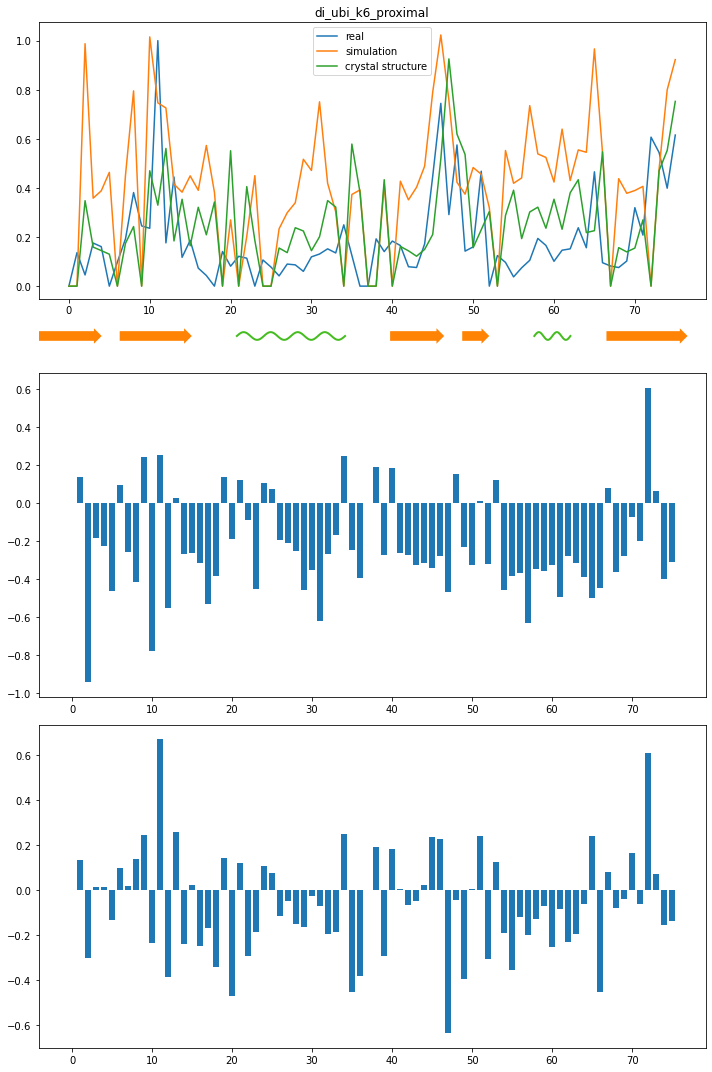

In [90]:
plt.close('all')

fig, (ax, ax3, ax4) = plt.subplots(nrows=3, figsize=(10, 15))

ax.plot(real / real.max(), label='real')
ax.plot(sim, label='simulation')
ax.plot(cryst, label='crystal structure')
ax.set_title('di_ubi_k6_proximal')
    
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
ax2 = ax_divider.append_axes("bottom", size="7%", pad="10%")
graphics.plot_feature_map(
    ax2, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)

diffs = real / real.max() -sim
ax3.bar(x=np.arange(len(diffs)), height=diffs)

diffs = real / real.max() -cryst
ax4.bar(x=np.arange(len(diffs)), height=diffs)

ax.legend()
fig.tight_layout()

## Plan B: Search in MD for structure with minimal values

Did this for clusters

In [95]:
K6_sPRE = make_sPRE_table('full_observables/spre_and_relaxation_data_k6_k29/di_ub2_k6_*_sPRE.txt', split_prox_dist=True)
real = K6_sPRE[K6_sPRE['position'] == 'proximal']['sPRE'].values
real[np.isnan(real)] = 0

diffs = []

for i, cluster_dir in enumerate(glob.glob('AA_clusters_trained_with_complete/*/')):
    traj = md.load(f"AA_clusters_trained_with_complete/{i}/cluster_{i}_cart_centroid.pdb")

    # renumber
    for r in traj.top.residues:
        if r.index > 75:
            r.resSeq += 76
        if r.name == 'GLQ':
            r.name = 'GLY'
        if r.name == 'LYQ':
            r.name = 'LYS'

    traj = traj.atom_slice(traj.top.select('residue <= 76'))
    traj.save_pdb(f'AA_clusters_trained_with_complete/{i}/cluster_{i}_cart_centroid_proximal.pdb')
    
    cmd = f"./single_struct_restraints.py -pdb AA_clusters_trained_with_complete/{i}/cluster_{i}_cart_centroid_proximal.pdb"
    
    process = subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE, shell=True)
    out, err = process.communicate()
    return_code = process.poll()
    out = out.decode(sys.stdin.encoding)
    err = err.decode(sys.stdin.encoding)
    out = out.split('findImportantAtoms: done')[1]
    out = ast.literal_eval(out)
    values = [0 for i in range(len(real))]
    for o in out:
        if o[0] == 'psol':
            id = int(o[1])
            values[id] = o[2]
    values = np.array(values)
    diff = real - values
    diffs.append([i, diff, values])

In [100]:
min_diff = np.array([np.mean(i[1]) for i in diffs])
min_diff = np.argmin(min_diff)
min_diff = diffs[min_diff]
print(min_diff)

[35, array([ 0.        ,  4.02478859,  0.94647651,  5.01986661,  4.5626012 ,
       -0.14159641,  2.90490908,  5.50171644, 11.03437497,  7.23768707,
        6.53630869, 29.05239175,  4.59878056, 12.89268953,  3.04769919,
        5.32987038,  1.86245077,  1.06428264, -0.30626412,  4.16001041,
        1.82989861,  3.58748046,  2.98085759, -0.18254716,  3.14411236,
        2.28840268,  1.07598656,  2.52357372,  2.33877067,  1.57334938,
        3.37474734,  3.66135675,  4.08176783,  3.69009125,  7.37128119,
        2.91682505, -0.30906458,  0.        ,  5.68192276,  3.58683879,
        5.41755603,  4.71236737,  2.23488357,  2.19945951,  5.00652133,
       12.76243137, 20.9794766 ,  6.66803348, 15.99824428,  3.82960528,
        4.69958804, 13.64180566, -0.33651467,  3.68052278,  2.44396495,
        0.71479545,  2.02577016,  2.80476875,  5.35146643,  4.64706836,
        2.43625542,  4.05568742,  4.15940393,  6.5393724 ,  4.36477928,
       13.48961019,  2.42495293,  2.42004883,  2.01499779, 

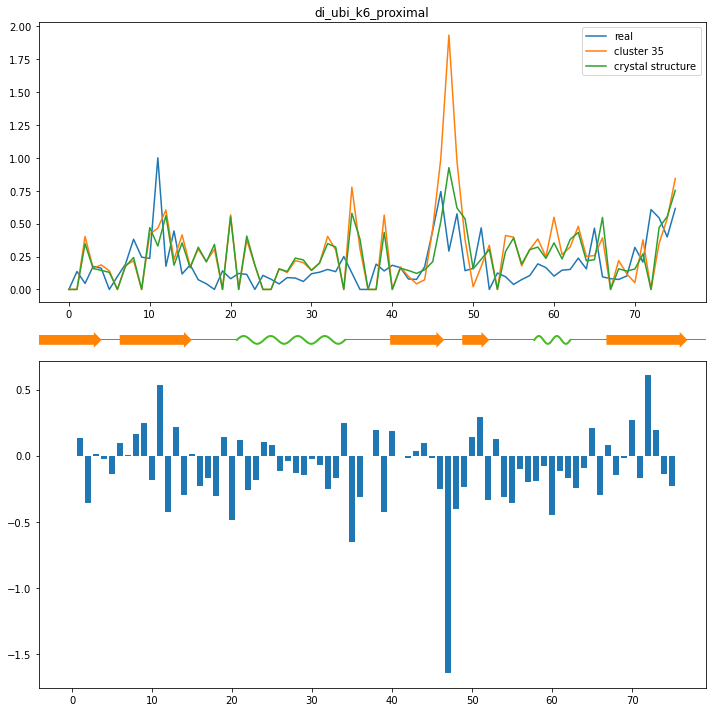

In [103]:
plt.close('all')

fig, (ax, ax3) = plt.subplots(nrows=2, figsize=(10, 10))

ax.plot(real / real.max(), label='real')
ax.plot(min_diff[2], label='cluster 35')
ax.plot(cryst, label='crystal structure')
ax.set_title('di_ubi_k6_proximal')
    
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
ax2 = ax_divider.append_axes("bottom", size="7%", pad="10%")
graphics.plot_feature_map(
    ax2, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)

diffs = real / real.max() - min_diff[2]
ax3.bar(x=np.arange(len(diffs)), height=diffs)


ax.legend()
fig.tight_layout()

## Calculate values for every simulation frame

In [143]:
traj = md.load("/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc", top="/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/start.pdb", stride=25)
view = ngl.show_mdtraj(traj)
view

NGLWidget(max_frame=200)

In [148]:
df = pd.read_csv('values_from_every_frame/df.csv')
df

,Unnamed: 0,traj_file,top_file,frame,time,proximal sPRE 1,proximal sPRE 2,proximal sPRE 3,proximal sPRE 4,proximal sPRE 5,...,distal 15N_800 67,distal 15N_800 68,distal 15N_800 69,distal 15N_800 70,distal 15N_800 71,distal 15N_800 72,distal 15N_800 73,distal 15N_800 74,distal 15N_800 75,distal 15N_800 76
0,0,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,0,0.0,0,0.347952,0.159007,0.144824,0.130072,...,5.199397,5.190182,5.184549,5.453839,5.067435,0,0,0,0,0
1,1,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,1,10.0,0,0.401411,0.166108,0.147395,0.143295,...,5.151355,5.199232,5.456631,5.476048,5.201436,0,0,0,0,0
2,2,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,2,20.0,0,0.456416,0.172267,0.165954,0.131275,...,5.174957,5.292606,5.236415,5.185381,5.101183,0,0,0,0,0
3,3,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,3,30.0,0,0.411437,0.160911,0.140879,0.127955,...,5.222061,5.245869,5.173551,5.345472,5.109086,0,0,0,0,0
4,4,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,4,40.0,0,0.397960,0.154016,0.141091,0.122090,...,5.268866,5.211415,5.304085,5.344679,5.105130,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1569,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,1569,15690.0,0,0.360096,0.162170,0.151051,0.147083,...,5.257638,5.281821,5.228476,5.256980,5.178534,0,0,0,0,0
1570,1570,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,1570,15700.0,0,0.353108,0.166630,0.155506,0.147694,...,5.098882,4.990351,5.108554,5.074385,5.134503,0,0,0,0,0
1571,1571,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,1571,15710.0,0,0.442170,0.170910,0.167274,0.142010,...,5.055930,4.994621,4.946012,4.959250,4.854509,0,0,0,0,0
1572,1572,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...,1572,15720.0,0,0.400338,0.155574,0.169751,0.143054,...,5.077469,4.888026,4.868091,5.024819,5.082773,0,0,0,0,0


In [139]:
pd.value_counts(df['traj_file'])

/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k6_01_01/traj_nojump.xtc    1165
Name: traj_file, dtype: int64

In [140]:
columns = list(filter(lambda x: True if 'sPRE' in x and 'proximal' in x else False, df.keys()))
values_prox = df[columns].values
columns = list(filter(lambda x: True if 'sPRE' in x and 'distal' in x else False, df.keys()))
values_dist = df[columns].values
# values = np.vstack(np.split(values, 2, axis=1))
# print(values.shape)

No handles with labels found to put in legend.


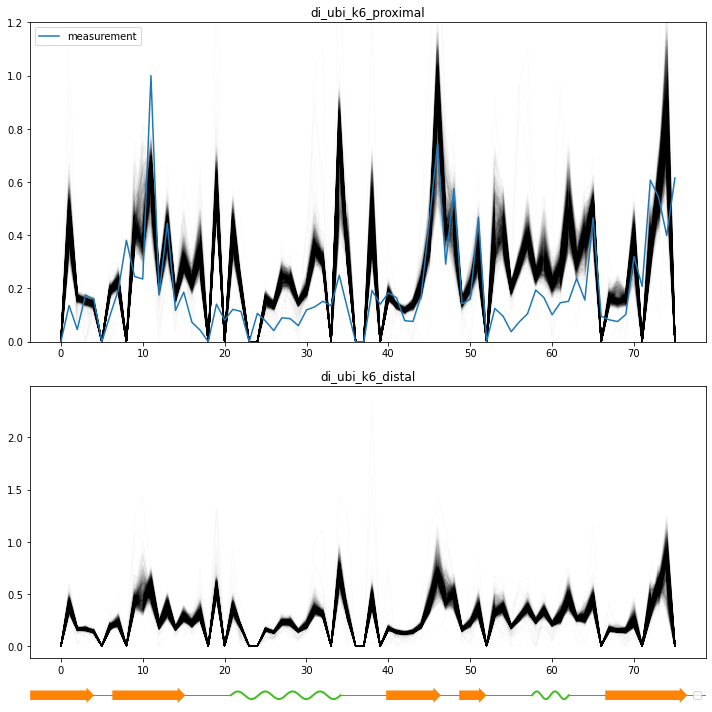

In [154]:
plt.close('all')

fig, (ax2, ax) = plt.subplots(nrows=2, figsize=(10, 10))

ax2.set_title('di_ubi_k6_proximal')
for j in values_prox:
    ax2.plot(j, c='k', alpha=0.01)
ax2.plot(real / real.max(), label='measurement')
ax2.legend()
ax2.set_ylim([0, 1.2])

ax.set_title('di_ubi_k6_distal')
for i in values_dist:
    ax.plot(i, c='k', alpha=0.01)
    
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
ax2 = ax_divider.append_axes("bottom", size="7%", pad="10%")
graphics.plot_feature_map(
    ax2, ubq_sec_annotation, multi_line=False, loc_range=(1,75),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)

ax2.legend()
fig.tight_layout()